In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/home/hdsingh/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series) 
    
    def next_batch(self,batch_size,steps,return_batch_ts = False):
        
        #Grab random starting point for each batch
        rand_start = np.random.rand(batch_size,1 )
        
        #Convert to be on time series
        ts_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        #Create batch time series on x axis
        batch_ts = ts_start + np.arange(0.0,steps+1)*self.resolution
        
        #Create Y data for time series x axis from previous step
        y_batch = np.sin(batch_ts)
        
        #Formatting for RNN
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1),batch_ts
            #also x_axis info
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)
            #shifted time series
        

In [3]:
ts_data = TimeSeriesData(250,0,10)

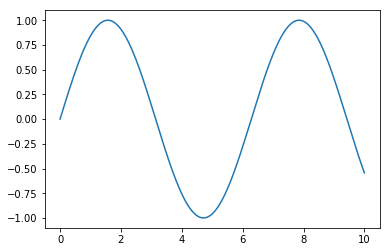

In [4]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1,y2,ts = ts_data.next_batch(1, num_time_steps, return_batch_ts=True)

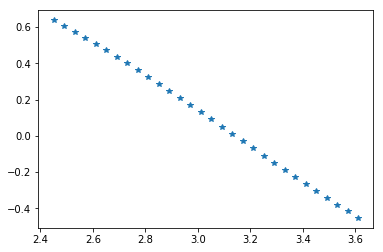

In [7]:
plt.plot(ts. flatten()[1:],y2.flatten(),'*')

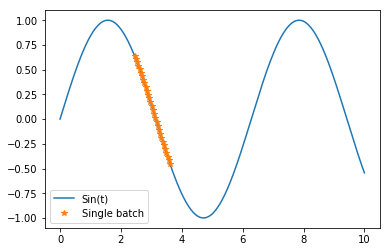

In [8]:
plt.plot(ts_data.x_data,ts_data.y_true,label = 'Sin(t)')
plt.plot(ts. flatten()[1:],y2.flatten(),'*',label = 'Single batch')
plt.legend()

In [9]:
train_inst = np.linspace(5,5 + ts_data.resolution*(num_time_steps + 1),num_time_steps+1)

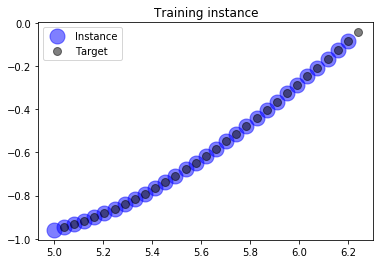

In [10]:
plt.title("Training instance")

plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize = 15,alpha =0.5,label='Instance')
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',markersize = 8,alpha =0.5,label='Target')
plt.legend()

## Create the Model

In [11]:
tf.reset_default_graph()

In [12]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
lr = 0.001
num_training_instance = 2000
batch_size = 1

In [13]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

In [ ]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
   tf.contrib.rnn.GRUCell(num_units=num_neurons,activation=tf.nn.relu),
                                              output_size=num_outputs)

In [ ]:
outputs, states =tf.nn.dynamic_rnn(cell,X,dtype = tf.float32)

In [ ]:
loss = tf.reduce_mean(tf.square(outputs - y))

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(loss)

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.85)

In [ ]:
saver = tf.train.Saver()

In [ ]:
num_train_iterations = 1000

In [ ]:
with tf.Session(config=tf.ConfigProto(gpu_options = gpu_options)) as sess:
    
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        X_batch, y_batch = ts_data.next_batch(batch_size,num_time_steps)
        sess.run(train,feed_dict = {X:X_batch,y:y_batch})
        
        if iteration%100 == 0:
            mse = loss.eval(feed_dict = {X:X_batch,y: y_batch})
            print(iteration,"\tMSE",mse)
    
    saver.save(sess,'./rnnModel1')

In [ ]:
with tf.Session() as sess:
    saver.restore(sess,'./rnnModel1')
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs, feed_dict= {X:X_new})

In [ ]:
plt.title("Testing the model")

#training instance
plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),'bo',markersize = 15, alpha = 0.5,label = 'Training instance')

#target to predict (correct test values np.sin(train))
plt.plot(train_inst[1:],np.sin(train_inst[1:]),'ko',markersize = 10,label = 'Target')

#models prediction
plt.plot(train_inst[1:],y_pred[0,:,0],'r.',markersize = 10, label = 'Prediction ')

plt.xlabel('Time')
plt.legend()


## Generating New Sequence

In [ ]:
with tf.Session() as sess:
    saver.restore(sess,'./rnnModel1')
    
    #Seed Zeros
    zeros_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        
        X_batch = np.array(zeros_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        
        zeros_seq_seed.append(y_pred[0, -1, 0])

In [ ]:
plt.plot(ts_data.x_data, zeros_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], zeros_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [ ]:
with tf.Session() as sess:
    saver.restore(sess,'./rnnModel1')
    
    
    train_inst = list(ts_data.y_true[:30])
    
    for iteration in range(len(train_inst)-num_time_steps):
        
        X_batch = np.array(train_inst[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs,feed_dict={X:X_batch})
        
        zeros_seq_seed.append(y_pred[0, -1, 0])

In [ ]:
plt.plot(ts_data.x_data, ts_data.y_true, "b-")
plt.plot(ts_data.x_data[:num_time_steps], train_inst[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")